***
# HCI Week 9 - Molecule Mapping
*Rico Landman & Matthew Kenworthy - Leiden Observatory*

***
Over the last weeks we have been looking at multiple techniques that are used in the field of High Contrast Imaging. In HCI we have techniques that rely on angular, spectral, phase as well as polarimetric diversities. 
Another diversity that can be used is the difference in the spectrum of the planet and the star.


## Molecule Mapping (MM)
Most stars are too hot to have molecules in their atmospheres, while planets do have molecules in their atmospheres. This allows us to distinguish between stellar speckles and a planet by identying molecular features in the observed spectra. We refer to this method as Molecule Mapping. The method does not depend on PSF wavelength scaling techniques (Spectral Differential Imaging; [Mawet et al. (2012)](https://www.aanda.org/articles/aa/pdf/2012/08/aa19662-12.pdf)), and neither on field rotation methods (Angular Differential Imaging; [Marois et al. (2006)](https://ui.adsabs.harvard.edu/link_gateway/2006ApJ...641..556M/PUB_PDF)). 
This makes Molecule Mapping a powerful method to look companions located at small angular distances from their host star where residual speckles are strongest. 

[Hoeijmakers et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018A%26A...617A.144H/abstract) used Molecule Mapping to investigate the molecular absorption of beta Pictoris b; finding molecules in its atmosphere.

In this weeks tutorial we will go through the analysis to detect beta Pictoris b and see which molecules are present in its atmosphere. We are using the dataset of Hoeijmakers et al. (2018). The data is taken with VLT/SINFONI in the K-band. SINFONI has a spectral resolution of about 5,000. Because beta Pictoris is very bright and SINFONI does not have a coronagraph, the star was placed outside the field of view. Still, the halo of the starlight is dominant and we can not see the planet without any post-processing.


This notebook will guide you through the following steps:
* [*Loading, inspecting and derotating the datacube*](#data)
* [*Removing stellar contribution*](#removestellar)
* [*Removing systematics with Principal Component Analysis*](#pca)
* [*Loading molecular absorption templates*](#absorption)
* [*Cross correlation: Detecting molecules in the atmosphere of beta Pictoris b*](#cross-correlation)


Let us first load Python modules and define some utility functions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
from scipy.ndimage import gaussian_filter1d
from astropy.modeling import models, fitting

# added plotting conv
import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')
from matplotlib.patches import Circle


def wfits(im, fname):
    """wfits - write im to file fname, automatically overwriting any old file"""
    from astropy.io import fits
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, overwrite=True)

def r_theta(im, xc, yc):
    """r_theta - make a radius mask and return the radius rr and the angle phi for point (xc,yc)"""
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

from scipy.ndimage import affine_transform
def cen_rot2 (im, rot, dim_out, offset1=(0,0), offset2=(0,0), order=2):
    """cen_rot2 - takes a cube of images im, and a set of rotation angles in rot,
                and translates the middle of the frame with a size dim_out to the middle of
                a new output frame with an additional rotation of rot degrees.
                """
    a = rot * np.pi / 180.
    
    # make a rotation matrix
    transform=np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    
    # calculate total offset for image output by (1) and (2)

    # (1) determine centre of input image

    c_in = np.array(offset1) - 0.5             # -0.5 to get rit off fencepost counting error
    c_out = 0.5 * np.array(dim_out) - 0.5      # -0.5 to get rit off fencepost counting error

    # (2) c_out has to be pre-rotated to make offset correct
    offset = c_in - c_out.dot(transform) - np.array(offset2).dot(transform)
    
    # perform the transformation
    dst=affine_transform( \
        im,transform.T, order=order,offset=offset, \
        output_shape=dim_out, cval=0.0)
    return(dst)

from scipy.signal import savgol_filter
def lowpass_filter(spectrum, window):
    return savgol_filter(spectrum, window, 3)

<a id='data'></a> 

### Inspecting the data

First, we will inspect the data. Read in the datacubes stored in 'SINFONI_beta_pic.fits' and the corresponding wavelengths. You can use the command `hdul.info()` to check which data array contains the data and which data array contains the wavelengths. 


The datacube is a set of 23 exposures of a 58x58 pixel image over 2058 spectral channels. The data is stored as (exposures, X, Y, wavelength). 

---
<span style="  font-size:2em; color: SteelBlue;">Question 9.1</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): 
 
Let us inspect the datacube: for the first exposure, sum over all the wavelengths to obtain a single image `Exp0_sum`

1.  **Plot `Exp0_sum`. Add a colorbar to look at the values of the image.**

We can also take a look at single spectra. 

2.  **Plot the spectrum of the 5th exposure, 50th row and 20th column.**
</span>

In [2]:
hdul = fits.open('SINFONI_beta_pic.fits')

Filename: SINFONI_beta_pic.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  CUBES         1 ImageHDU        10   (2058, 58, 58, 23)   float32   
  2  WAVE          1 ImageHDU         7   (2058,)   float64   
(23, 58, 58, 2058)


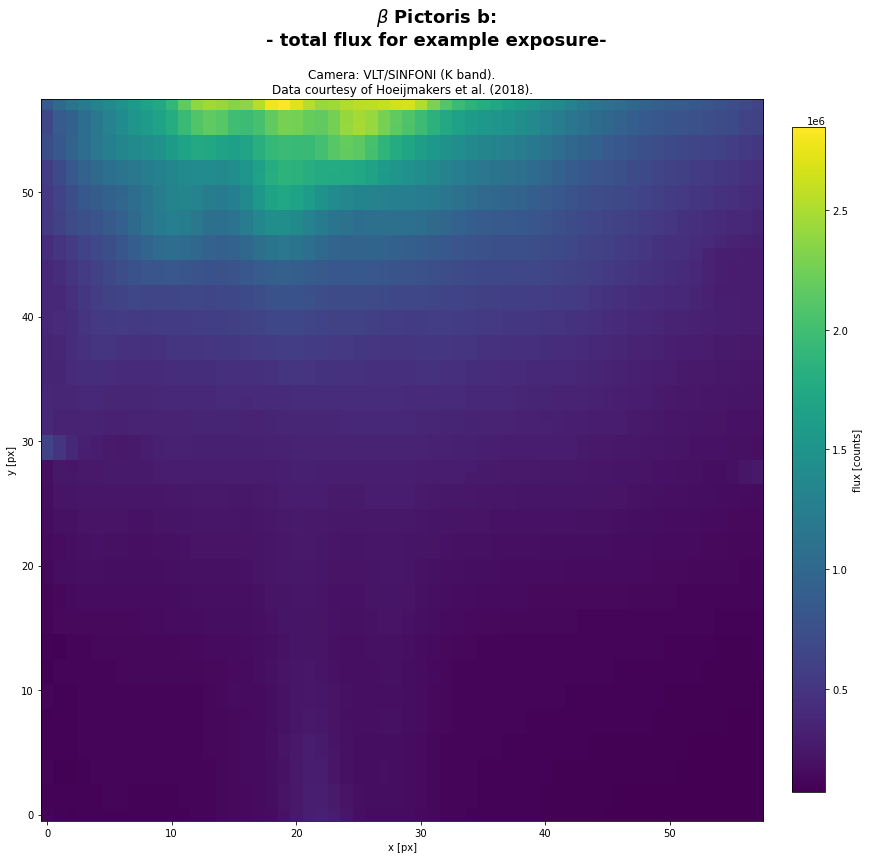

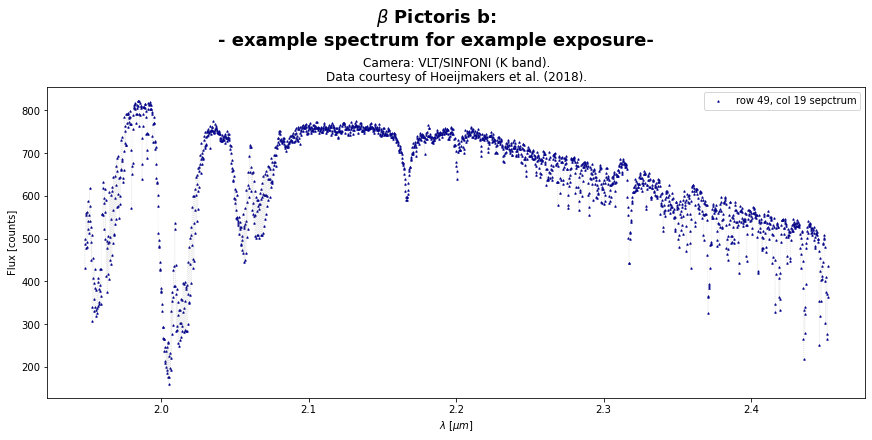

In [3]:
# Q1 answer here
hdul.info()

cubes = hdul["CUBES"].data
wave = hdul["WAVE"].data
print(cubes.shape)

Exp0_sum = np.sum(cubes[0], axis=-1)
Exp0_sum.shape

fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(Exp0_sum,
                    vmax=None, vmin=None)

plt.colorbar(this_im, ax=ax, label=r"flux [counts]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- total flux for example exposure-', fontsize=18, weight="bold")
plt.show()

# ==============================================

_Exp5_spec = cubes[4, 49, 19]

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

ax.plot(wave, _Exp5_spec, c="gray", ls="dotted", alpha=0.2, lw=0.75)
ax.scatter(wave, _Exp5_spec, c="darkblue", marker="^", label="row 49, col 19 sepctrum", s=2)

ax.set_xlabel(r'$\lambda$ [$\mu m$]')
ax.set_ylabel(r'Flux [counts]')

ax.legend()
ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- example spectrum for example exposure-', fontsize=18, weight="bold")
plt.show()



# Q1 end of answer

The data were taken in pupil stabilized mode as the initial idea of the observations was to apply Angular Differential Imaging. We therefore first have to derotate the images for all the spectral bins and all the datacubes. 

---
<span style="  font-size:2em; color: SteelBlue;">Question 9.2</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): 


1. **Load the rotation angles that are stored in 'par_angles.txt'.**
2. **Derotate all 23 data cubes and store the cubes in `total_cube`. Make sure that the output image contains all the pixel information of the entire cubes, by extending the size of the derotated image to 78x78 pixels.**


****

In [4]:
# Q2 answer here
rot = np.loadtxt("par_angles.txt")
c_shape = cubes.shape
print(cubes.reshape(-1, *c_shape[1:3]).shape)
print(rot.repeat(wave.size).shape)

rolled_cube = np.moveaxis(cubes, -1, 1)
print(rolled_cube.shape)
rolled_cube = rolled_cube.reshape(-1, 58, 58)
print(rolled_cube.shape)


# wrong function docstring for cen_rot2, wtf??
total_cube = np.array([cen_rot2(cube, r, (78, 78), offset1=(58/2, 58/2)) for cube, r in zip(rolled_cube,
                                                                       -rot.repeat(wave.size))])
print(total_cube.shape)
total_cube = total_cube.reshape(c_shape[0], c_shape[-1], 78, 78)
print(total_cube.shape)
total_cube = np.moveaxis(total_cube, 1, -1)
print(total_cube.shape)

# Q2 end of answer

(47334, 58, 58)
(47334,)
(23, 2058, 58, 58)
(47334, 58, 58)
(47334, 78, 78)
(23, 2058, 78, 78)
(23, 78, 78, 2058)


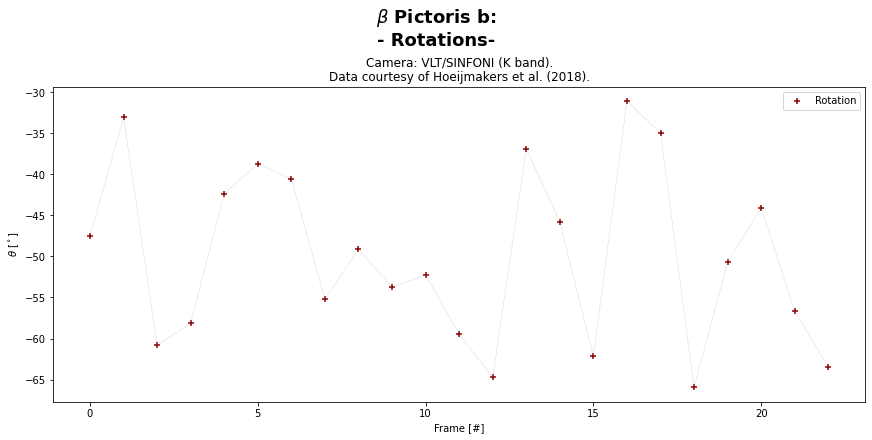

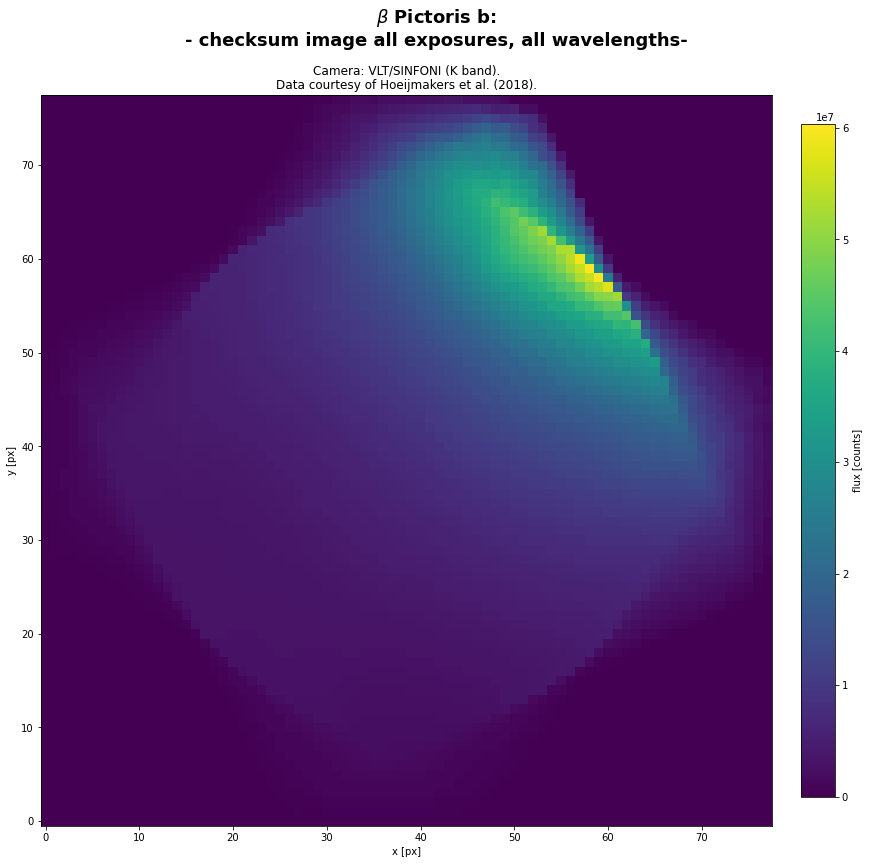

In [5]:
# check


fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

x = np.arange(len(rot))

ax.plot(x, rot, c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(x, rot, c="darkred", marker="+", label="Rotation")

ax.set_xlabel(r'Frame [#]')
ax.set_ylabel(r'$\theta$ [$^\circ$]')
ax.legend()
ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- Rotations-', fontsize=18, weight="bold")
plt.show()

checksum_img = np.sum(total_cube, axis=(0, 3))

fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(checksum_img,
                    vmax=None, vmin=None)

plt.colorbar(this_im, ax=ax, label=r"flux [counts]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- checksum image all exposures, all wavelengths-', fontsize=18, weight="bold")
plt.show()


<a id='removestellar'></a> 
### Removing the stellar contribution

The spectrum of each spatial pixel (spaxel) consists of a contribution from the star, a possible planet and some noise. The second step in our data reduction is to remove the contribution from the star. This contribution consists of the stellar spectrum modulated by a low-order function that is the result of the wavelength dependence of the PSF of the star. This low-order modulation can be captured using a low-pass filter, while keeping the molecular features mostly intact.

---
<span style="  font-size:2em; color: SteelBlue;">Question 9.3</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>





We will construct a model of the contribution of the star to each spaxel and subtract this. We can do this using the following steps: 

1. **Construct a master spectrum `master_spectrum` of the star by taking the mean over all spaxels.**
2. **Divide every spaxel by this master spectrum to get the modulation.**
3. **Apply a low-pass filter to this modulation to only keep the low-order speckle modulation. A good value for the spectral window is 201.**
4. **Multiply the model of the modulation with the master spectrum and remove this from the spectrum.**

Let us apply this to a single spaxel to see what is happening at every step. 

**Select & plot a random spaxel (with enough light) AND plot the result of every step as explained above.**

****

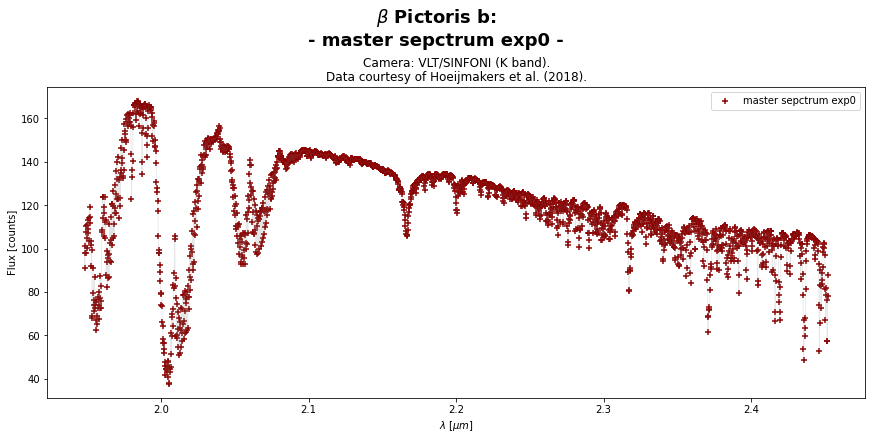

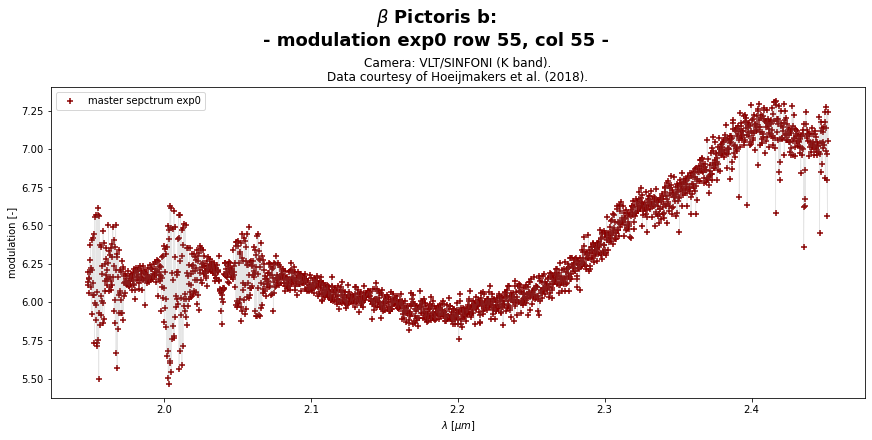

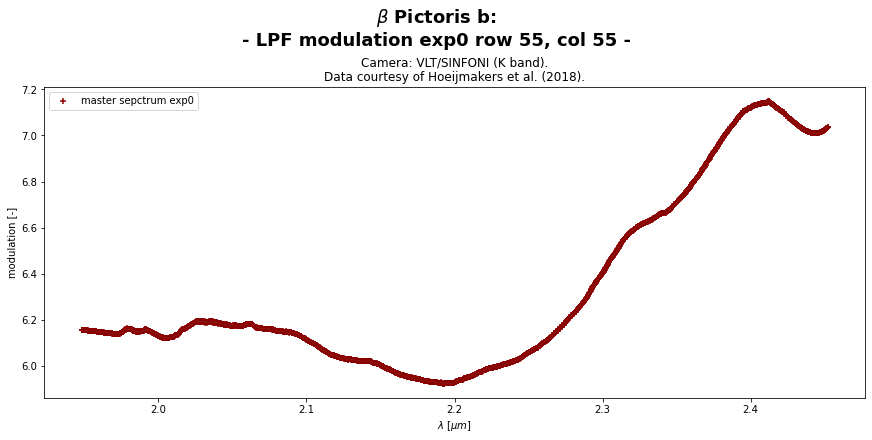

In [6]:
# Q3 answer here
    

master_spectrum = np.mean(total_cube, axis=(1, 2))
# master_spectrum = np.median(total_cube, axis=(1,2))

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

ax.plot(wave, master_spectrum[0], c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(wave, master_spectrum[0], c="darkred", marker="+", label="master sepctrum exp0")

ax.set_xlabel(r'$\lambda$ [$\mu m$]')
ax.set_ylabel(r'Flux [counts]')
ax.legend()
ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- master sepctrum exp0 -', fontsize=18, weight="bold")
plt.show()


#  ========================================

modulation = total_cube / master_spectrum.reshape(23,1,1,2058)

_modulation = modulation

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

ax.plot(wave, _modulation[0, 55, 55], c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(wave, _modulation[0, 55, 55], c="darkred", marker="+", label="master sepctrum exp0")

ax.set_xlabel(r'$\lambda$ [$\mu m$]')
ax.set_ylabel(r'modulation [-]')
ax.legend()
ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- modulation exp0 row 55, col 55 -', fontsize=18, weight="bold")
plt.show()

# =========================================

modulation = np.array([lowpass_filter(mod, 201) for mod in modulation.reshape(-1, wave.size)])
modulation = modulation.reshape(*total_cube.shape)


fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

ax.plot(wave, modulation[0, 55, 55], c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(wave, modulation[0, 55, 55], c="darkred", marker="+", label="master sepctrum exp0")

ax.set_xlabel(r'$\lambda$ [$\mu m$]')
ax.set_ylabel(r'modulation [-]')
ax.legend()
ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- LPF modulation exp0 row 55, col 55 -', fontsize=18, weight="bold")
plt.show()

# Q3 end of answer

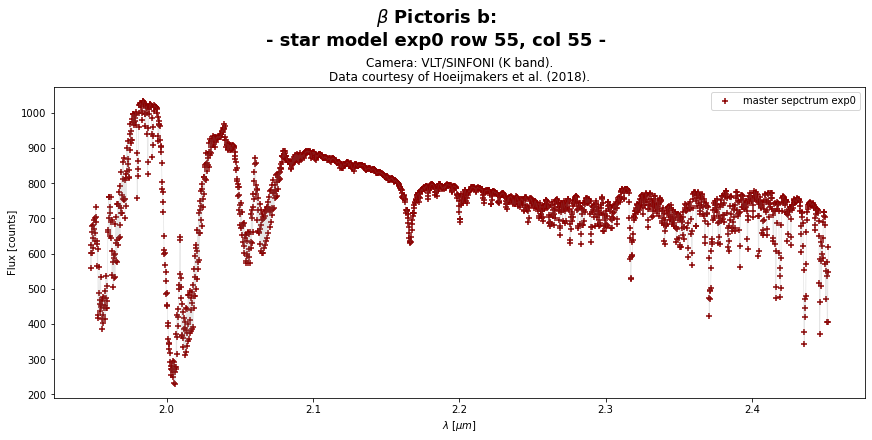

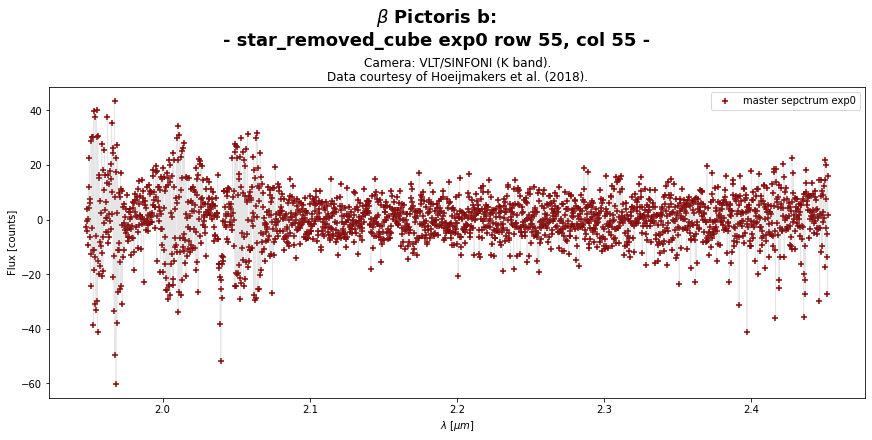

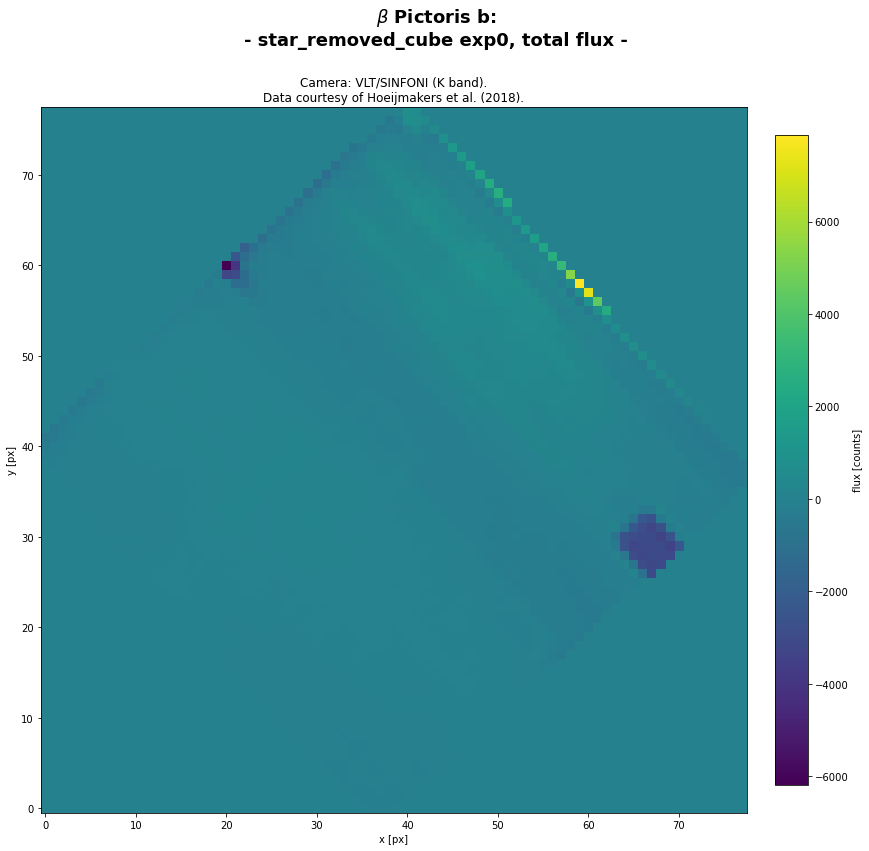

In [7]:
star = modulation * master_spectrum.reshape(23,1,1,2058)


fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

ax.plot(wave, star[0, 55, 55], c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(wave, star[0, 55, 55], c="darkred", marker="+", label="master sepctrum exp0")

ax.set_xlabel(r'$\lambda$ [$\mu m$]')
ax.set_ylabel(r'Flux [counts]')
ax.legend()
ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- star model exp0 row 55, col 55 -', fontsize=18, weight="bold")
plt.show()


star_removed_cube = total_cube - star


fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

ax.plot(wave, star_removed_cube[0, 55, 55], c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(wave, star_removed_cube[0, 55, 55], c="darkred", marker="+", label="master sepctrum exp0")

ax.set_xlabel(r'$\lambda$ [$\mu m$]')
ax.set_ylabel(r'Flux [counts]')
ax.legend()
ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- star_removed_cube exp0 row 55, col 55 -', fontsize=18, weight="bold")
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(np.sum(star_removed_cube[0], axis=-1),
                    vmax=None, vmin=None)

plt.colorbar(this_im, ax=ax, label=r"flux [counts]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- star_removed_cube exp0, total flux -', fontsize=18, weight="bold")
plt.show()

---
<span style="  font-size:2em; color: SteelBlue;">Question 9.4</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): </span>

**Repeat this process for every spaxel. Store the results in a cube `star_removed_cube`.**

In [8]:
# Q4 answer here
    
# see above
    
# Q4 end of answer

<a id='pca'></a> 
### Removing systematics with Principal Component Analysis

While we have now successfully removed the stellar contribution from each of the spaxels there may still be shared systematics in all the spaxels. These may for example be due to residual lines from the Earth's atmosphere. 

To remove these systematics we will use PCA to look for the principle components. The analysis in done in a similar way as we did for ADI. Only, instead of obtaining the "eigen images" we apply PCA along the spectral dimension to obtain the "eigen spectra". The contribution of the planet only appears in a few spaxels. Therefore subtracting the first few PCA components avoids self-subtraction of the planet while subtracting the systematics.

---
<span style="  font-size:2em; color: SteelBlue;">Question 9.5</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

1. **Perform PCA on the `star_removed_cube`**
2. **Plot the first 5 "eigen spectra"**
3. **Subtract the first 10 PCA components from all the spaxels. Store the systematic substracted cube in`pca_subtracted`**
****

In [9]:
# Q5 answer here

med_star_removed_cube = np.median(star_removed_cube, axis=0)
mean_star_removed_cube = np.mean(star_removed_cube, axis=0)

flat_med_star_removed = med_star_removed_cube.reshape(-1, wave.size)

print(flat_med_star_removed.shape)

U, s, V = np.linalg.svd(flat_med_star_removed, full_matrices=False, compute_uv=True)
print("Shape of U:       {}".format(U.shape))
print("Shape of s:       {}".format(s.shape))
print("Shape of V:       {}".format(V.shape))

S = np.diag(s)

(6084, 2058)
Shape of U:       (6084, 2058)
Shape of s:       (2058,)
Shape of V:       (2058, 2058)


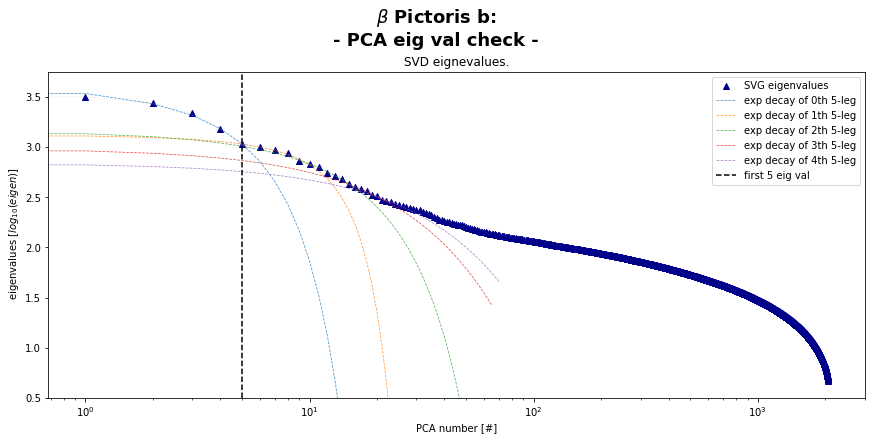

In [10]:

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

x = np.arange(len(s))

ax.plot(x, np.log10(s), c="gray", ls="dotted", alpha=0.2, lw=0.75)
ax.scatter(x, np.log10(s), c="darkblue", marker="^", label="SVG eigenvalues")

paras = []

try: 
    from scipy.optimize import curve_fit
    def model_eig_exp_decay(x, a, b, c):
        return a * np.exp(b * x) + c

    def fit_exp_dec(x, y):
        para, cov = curve_fit(model_eig_exp_decay, x, y, maxfev=10000,
                             p0=(1, 1, 1))
        a, b, c = para
        return a, b, c

    fit_using = 5
    for i, start in enumerate(np.arange(0, 25, fit_using)):
        _x = x[start:start+fit_using + 1]
        model_exp_decay_para = fit_exp_dec(_x, np.log10(s)[start:start+fit_using + 1])
        paras.append(model_exp_decay_para)
        __x = x[0:start+ 10 * fit_using + 1]
        model_exp_decay = model_eig_exp_decay(__x, *model_exp_decay_para)
        ax.plot(__x, model_exp_decay,
                ls="dashed", alpha=0.8, lw=0.75, label=f"exp decay of {i}th {fit_using}-leg")
except BaseException:
    print("If youre seeing this youre missing out!")
    pass

ax.set_ylim(0.5, 3.75)

ax.axvline(5, c="k", ls="dashed", label="first 5 eig val")

ax.set_xscale("log")

ax.set_xlabel(r'PCA number [#]')
ax.set_ylabel(r' eigenvalues [$log_{10}(eigen)$]')

ax.legend()
ax.set_title('SVD eignevalues.') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- PCA eig val check -', fontsize=18, weight="bold")
plt.show()


# Q5 end of answer

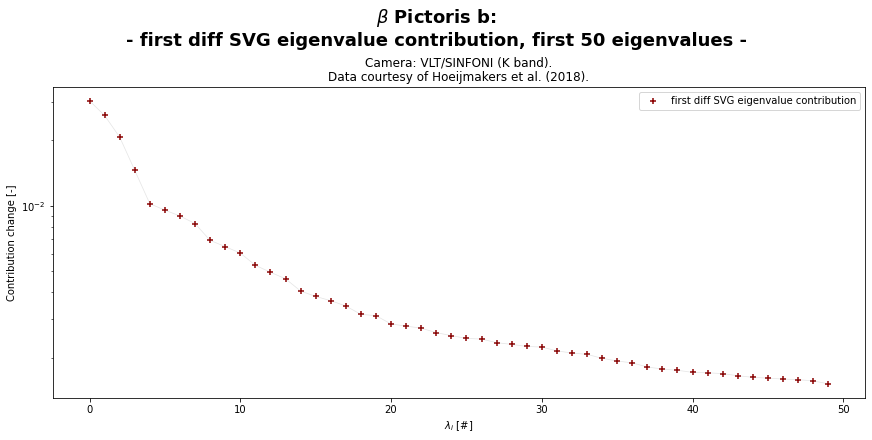

In [11]:
# value of including more eig:

# so the way I understand it we can essentailly see the value of including the eigenimages using s 
# since it shows the "weight" (eigenvalue) of each eigenimage

# How much do we gain by including more and more after the first one?
# Is 5 really a good choice?
#     We actually answered that before already when fitting exp. decays to the different legs of the eigenvalue

scumsum = np.cumsum(s)


value = scumsum / np.max(scumsum)
value = np.diff(value, n=1)

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

ax.plot(x[:50], value[:50], c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(x[:50], value[:50], c="darkred", marker="+", label="first diff SVG eigenvalue contribution")

ax.set_yscale("log")

ax.set_xlabel(r'$\lambda_{i}$ [#]')
ax.set_ylabel(r'Contribution change [-]')
ax.legend()
ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- first diff SVG eigenvalue contribution, first 50 eigenvalues -',
             fontsize=18, weight="bold")
plt.show()

We didnt learn anything new here because eigenvalues already carry a crazy amount of information. The only thing added with this is an estimator for the relative contribution of the eigenimages, which is sweet but not really useful for anything else here.

Looking at the plot with the exponential decays above, including 5 eigenimages is probably already pretty good to catch large variances and 10 is easily sufficent for removing the Earth's atmosphere and might actually start revemoving flux we are interested in. Without knowing/estimating the atmosphere (or other error sources) emission/absorbtion strength I think the exact number of eigenimages we include between 5 and maybe 20 is a little abitrary.

Anyway, back to the task...

In [12]:
k=10
Uk = U[:,:k]
sk = s[:k]
Vk = V[:k,:]

print("Shape of Uk:       {}".format(Uk.shape))
print("Shape of sk:       {}".format(sk.shape))
print("Shape of Vk:       {}".format(Vk.shape))

transformed = np.dot(Vk, flat_med_star_removed.T)
reconstructed = np.dot(transformed.T, Vk)

print("Shape of transformed:         {}".format(transformed.shape))
print("Shape of reconstructed:       {}".format(reconstructed.shape))

Shape of Uk:       (6084, 10)
Shape of sk:       (10,)
Shape of Vk:       (10, 2058)
Shape of transformed:         (10, 6084)
Shape of reconstructed:       (6084, 2058)


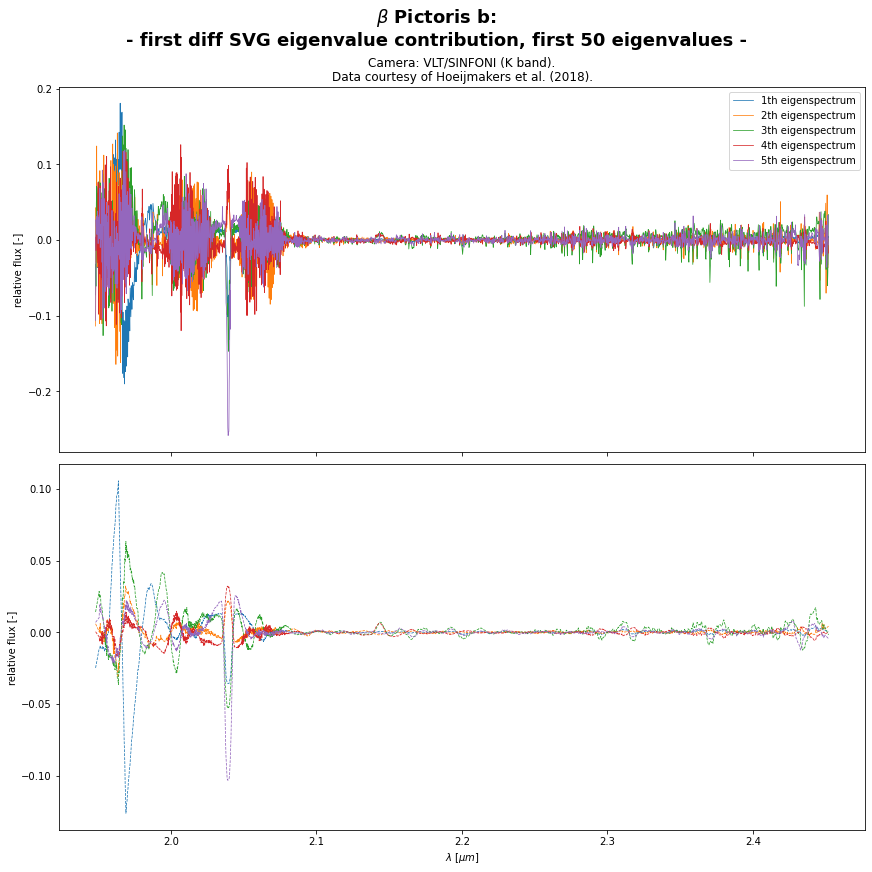

In [13]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12),
                             sharex=True)

for i, spec in enumerate(Vk[:5]):
    ax.plot(wave, spec, ls="solid", alpha=1., lw=0.75, label=f"{i+1}th eigenspectrum")
    ax1.plot(wave, savgol_filter(spec, 21, 1), ls="dashed", alpha=1., lw=0.75, label=f"{i+1}th eigenspectrum")

ax1.set_xlabel(r'$\lambda$ [$\mu m$]')
ax.set_ylabel(r'relative flux [-]')
ax1.set_ylabel(r'relative flux [-]')
ax.legend()
ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- first diff SVG eigenvalue contribution, first 50 eigenvalues -', fontsize=18, weight="bold")
plt.show()

(78, 78, 2058)
(23, 78, 78, 2058)


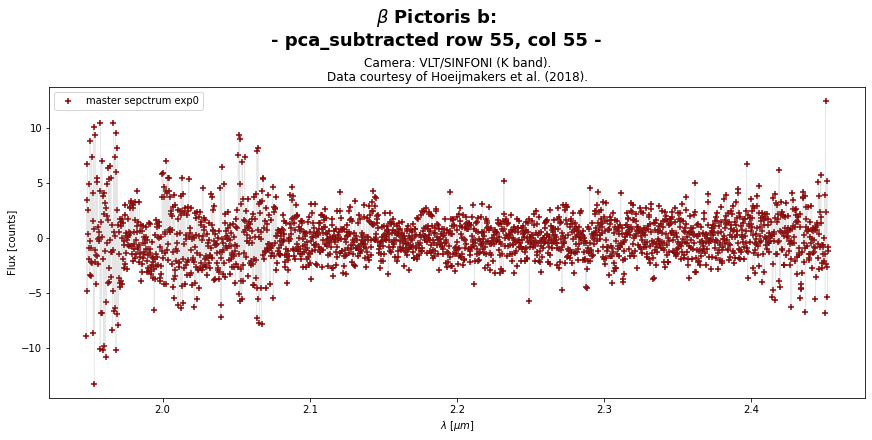

In [14]:
pca_subtracted = flat_med_star_removed - reconstructed
pca_subtracted = pca_subtracted.reshape(78, 78, wave.size)
print(pca_subtracted.shape)

full_pca_subtracted = star_removed_cube - reconstructed.reshape(78, 78, wave.size)
full_pca_subtracted = full_pca_subtracted.reshape(23, 78, 78, wave.size)
print(full_pca_subtracted.shape)


fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 6))

ax.plot(wave, pca_subtracted[55, 55], c="gray", ls="solid", alpha=0.2, lw=0.75)
ax.scatter(wave, pca_subtracted[55, 55], c="darkred", marker="+", label="master sepctrum exp0")

ax.set_xlabel(r'$\lambda$ [$\mu m$]')
ax.set_ylabel(r'Flux [counts]')
ax.legend()
ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- pca_subtracted row 55, col 55 -', fontsize=18, weight="bold")
plt.show()

<a id='absorption'></a> 

### Loading molecular absorption templates

We prepared three templates of the molecular absorption for you. They are stored in 'Molecule_templates.fits'. 

---

<span style="  font-size:2em; color: SteelBlue;">Question 9.6</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): </span>

**Inspect the fits file to idenfity for which molecules you have the templates. Load the templates. Plot the absorption spectra with the name of the molecule in the title. Do not forget your axis labels.**

---

Filename: Molecule_templates.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  WAVE          1 ImageHDU         7   (2684,)   float64   
  2  CH4           1 ImageHDU         7   (2684,)   float64   
  3  H2O           1 ImageHDU         7   (2684,)   float64   
  4  CO            1 ImageHDU         7   (2684,)   float64   


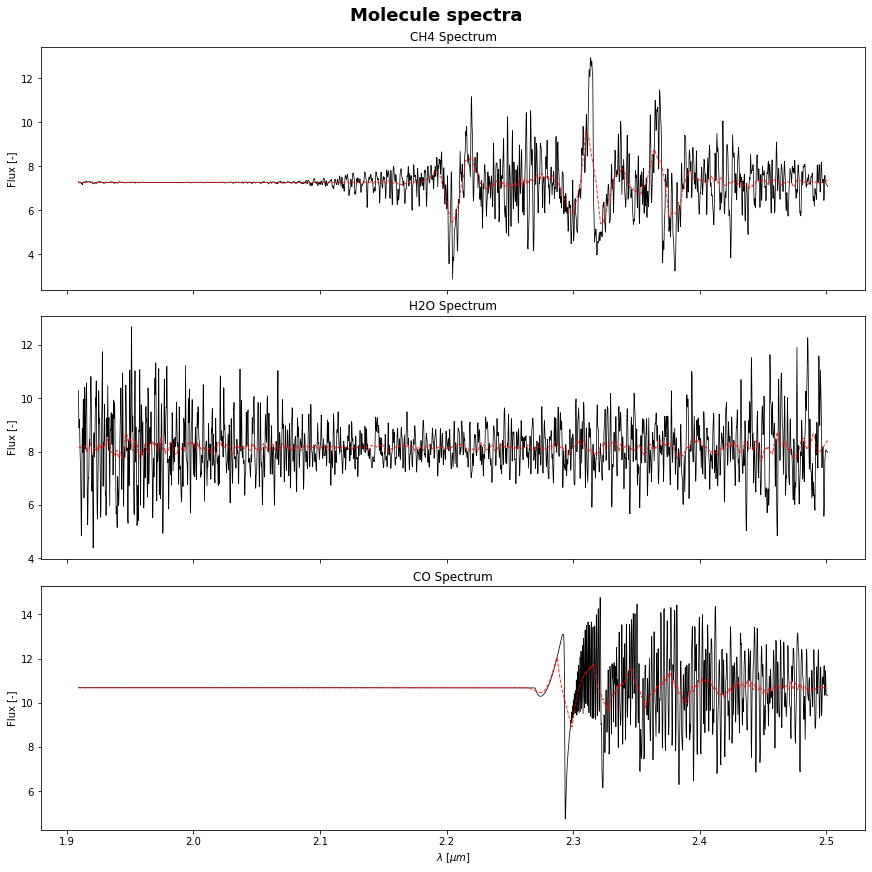

In [15]:
# Q6 answer here

hdul_mol = fits.open('Molecule_templates.fits')
hdul_mol.info()

mol_wave = hdul_mol["WAVE"].data

fig, axes = plt.subplots(nrows=3, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12),
                             sharex=True)

axes = np.array(axes).flatten()

for i, ax in enumerate(axes):
    name = hdul_mol[i+2].name
    ax.plot(mol_wave, hdul_mol[i+2].data, c="k", ls="solid", alpha=1., lw=0.75)
    ax.plot(mol_wave, savgol_filter(hdul_mol[i+2].data, 51, 1), c="red", ls="dashed", alpha=0.8, lw=1.)
    ax.set_ylabel(r'Flux [-]')
    ax.set_title(name + f" Spectrum") 

ax.set_xlabel(r'$\lambda$ [$\mu m$]')


fig.suptitle(r'Molecule spectra', fontsize=18, weight="bold")
plt.show()

# Q6 end of answer

<a id='cross-correlation'></a> 

### Cross-correlation

Write a function that takes as input a spectrum with its wavelengths, a template with its wavelengths and a range of radial velocities and returns the cross-correlation function.
The general steps in this function should be as follows:

1. Calculate the Doppler shifted wavelengths for the given radial velocities $ v$ using: $$\lambda' = (1- \frac{v}{c})\lambda$$
2. Interpolate the template to these shifted wavelengths.
3. Calculate the correlation coefficient:

$$C = \frac{1}{N}\sum_i^N \frac{(x_i-\bar{x})(t_i - \bar{t})}{\sigma_x \sigma_t}.$$

---

<span style="  font-size:2em; color: SteelBlue;">Question 9.7</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): </span>

1. **Write a function `cross_correlate` to do the cross-correlation.**


<div class="alert alert-block alert-info">
<b>Tip:</b> The function should have as input: the data, data wavelengths, template, template wavelengths and a range of radial velocities. The output should be obviously the cross correlation coefficient between the data and the template.</div>

2. **Cross-correlate the absorption spectra of the molecules with itself (the autocorrelation).**
3. **Plot the the resulting autocorrelation for all these molecules.**

---

I use numpys corrcoef function which is the Pearson correlation coefficient:

$$\rho_{X, Y}=\frac{\operatorname{cov}(X, Y)}{\sigma_{X} \sigma_{Y}}$$

for series X, Y.

Write as:
$$ \rho_{X, Y}=\frac{\mathbb{E}\left[\left(X-\mu_{X}\right)\left(Y-\mu_{Y}\right)\right]}{\sigma_{X} \sigma_{Y}} $$

and

$$ \rho_{X, Y}=\frac{\mathbb{E}[X Y]-\mathbb{E}[X] \mathbb{E}[Y]}{\sqrt{\mathbb{E}\left[X^{2}\right]-(\mathbb{E}[X])^{2}} \sqrt{\mathbb{E}\left[Y^{2}\right]-(\mathbb{E}[Y])^{2}}} $$

which is equivalent to the given estimator for the corr coef above when we take it its mean. So that here

$$ C = \frac{1}{n} r^{Pearson}_{x y}=\sum_{i=1}^{n}\frac{\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\sum_{i=1}^{n}\left(x_{i}-\bar{x}\right)^{2}} \sqrt{\sum_{i=1}^{n}\left(y_{i}-\bar{y}\right)^{2}}} $$

(equations shamelessly copy-pased from wikipedia)

In [16]:
# Q7 answer here

c = 299792458  # m/s
   

def cross_correlate(data, data_wavelengths, template, template_wavelengths, radial_velocities):
    for inp, name in zip((data, data_wavelengths, template, template_wavelengths, radial_velocities),
                         ("data", "data_wavelengths", "template", "template_wavelengths", "radial_velocities")):
        #print(f"{name} shape = {inp.shape}")
        #print(f"{name} = {inp}")
        pass
        
    _data_wavelengths = np.tile(data_wavelengths, (radial_velocities.size, 1))
    #print(f"{_data_wavelengths.shape = }")
    #print(_data_wavelengths)
    
    data_wl_shifted = (1 - radial_velocities.reshape(radial_velocities.size, 1)/c) * _data_wavelengths
    #print(f"{data_wl_shifted.shape = }")
    # shape (vel, wl)
    
    _template_interp = np.empty(shape=(radial_velocities.size, data_wavelengths.size), dtype=float)
    #print(f"{_template_interp.shape = }")
    
    for i_rad_vel, _1v_wl_shifted in enumerate(data_wl_shifted):
        _template_interp[i_rad_vel] = np.interp(_1v_wl_shifted, template_wavelengths, template,) 
        
    #print(f"{_template_interp.shape = }")
    #print(_template_interp)
       
    cross_correlation = np.zeros_like(radial_velocities)
    
    #print(f"{cross_correlation.shape = }")
    
    for i_rad_vel, _1v_wl_shifted in enumerate(_template_interp):
        cross_correlation[i_rad_vel] = np.corrcoef(_1v_wl_shifted, data)[0, 1]
    #print(f"{cross_correlation.shape = }")
    #print(cross_correlation)
    
    return cross_correlation

# Q7 end of answer

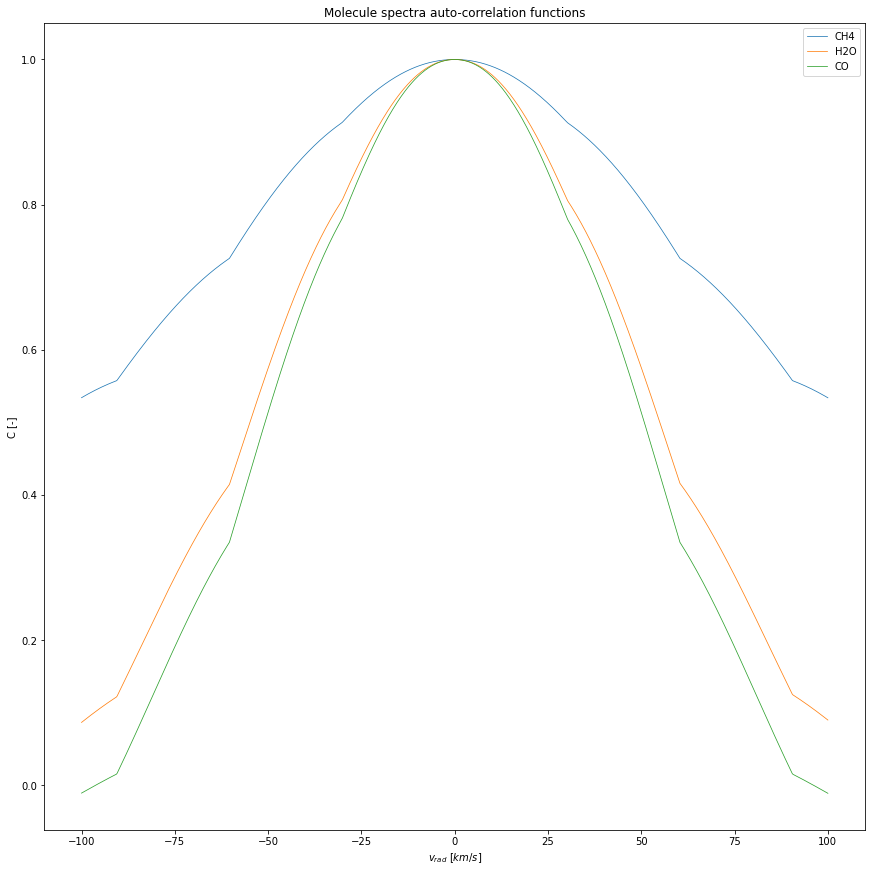

In [17]:
rad_vel = np.linspace(-1., 1., 1111) * 1000. * 100.

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(12, 12),
                             sharex=True)

# ax = np.array(axes).flatten()

for i in range(3):
    mol_autocorr = cross_correlate(hdul_mol[i+2].data, mol_wave, hdul_mol[i+2].data, mol_wave, rad_vel)
    
    name = hdul_mol[i+2].name
    ax.plot(rad_vel/1000., mol_autocorr, ls="solid", alpha=1., lw=0.75,
           label = name)
    ax.set_ylabel(r'C [-]')
    # ax.set_title(name + f"") 

ax.set_xlabel(r'$v_{rad}$ [$km/s$]')
ax.legend()

ax.set_title('Molecule spectra auto-correlation functions') 
# fig.suptitle(r'$\beta$ Pictoris b:'f'\n- Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018). -',
#              fontsize=18, weight="bold")
plt.show()

<a id='filter'></a> 
###  Detecting molecules in the atmosphere of beta Pictoris b

We now apply the cross-correlation to each of the spaxels of the cleaned datacube. For real data, we want to weight the data by the errors by the uncertainties. While we do not know the exact uncertainties we can estimate the variance in each spectral bin by taking the standard deviation across all spaxels.

---
---
In Question 9.8  PLEASE REMOVE the step: 

- Estimate the standard deviation $\sigma_i$ in each spectral bin.

Detecting molecules in the atmosphere of beta Pictoris b

We now apply the cross-correlation to each of the spaxels of the cleaned datacube. (((For real data, we want to weight the data by the errors by the uncertainties. While we do not know the exact uncertainties we can estimate the variance in each spectral bin by taking the standard deviation across all spaxels.)))

The underlined text might cause confusion. You do NOT need to take into account the weighting of the data during this tutorial. 

---
---

---
<span style="  font-size:2em; color: SteelBlue;">Question 9.8</span> <span style="  font-size:1em; color: SteelBlue;">
(2 points): </span>

1. **(((Estimate the standard deviation $\sigma_i$ in each spectral bin.)))**
2. **Calculate the cross-correlation between the template and each of the spaxels.**
3. **Plot the resulting molecule maps (78x78 pixels) for a velocity of 20 km/s**
4. **Plot the cross-correlation function at the location of the planet**

---

(78, 78)


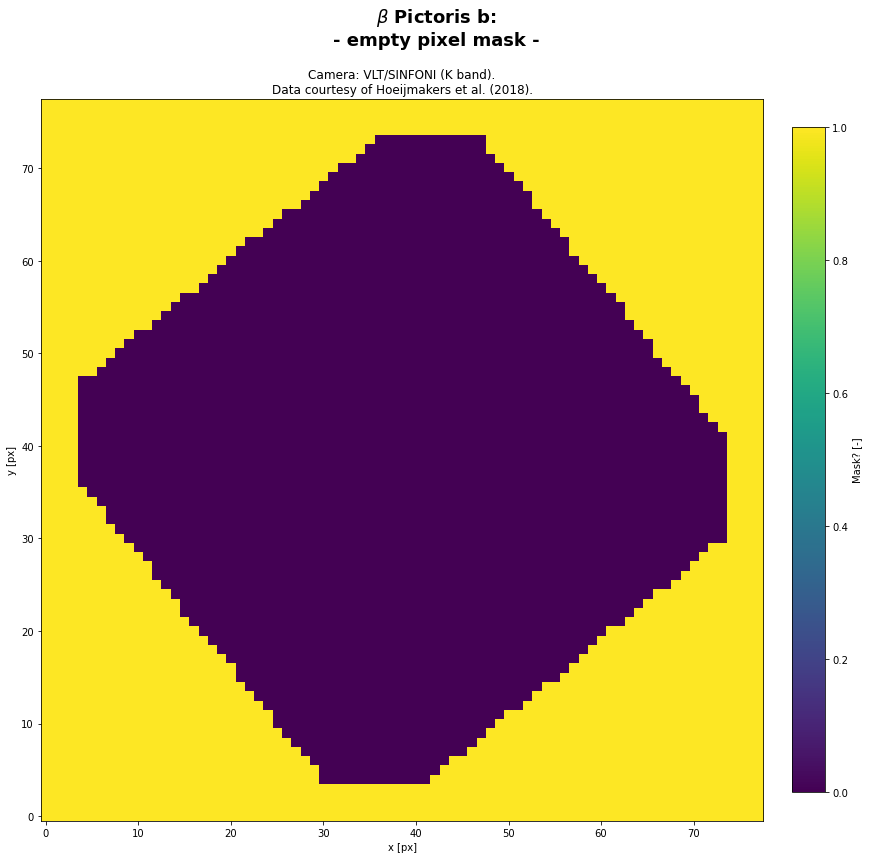

(6084, 2058)
(3152, 2058)


In [18]:
# Q8 answer here
# pca_subtracted

mask = np.sum(np.square(pca_subtracted), axis=-1) == 0.

print(mask.shape)

fig, ax = plt.subplots(nrows=1, ncols=1,
                     constrained_layout=True,
                     figsize=(12, 12)) # figsize=(width, height)

this_im = ax.imshow(mask,
                    vmax=None, vmin=None)

plt.colorbar(this_im, ax=ax, label=r"Mask? [-]", fraction=0.046, pad=0.04)
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')

ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
fig.suptitle(r'$\beta$ Pictoris b:'f'\n- empty pixel mask -', fontsize=18, weight="bold")
plt.show()

masked_pca_subtracted = np.ma.masked_where(np.moveaxis(np.tile(mask, (wave.size, 1, 1)), 0, -1), pca_subtracted, copy=True)
print(masked_pca_subtracted.reshape(-1, wave.size).shape)
masked_pca_subtracted = masked_pca_subtracted.compressed().reshape(-1, wave.size)
print(masked_pca_subtracted.shape)

In [19]:
# this was for testing and I am afraid to delete it :D

# x = pca_subtracted[59, 49]
# y = hdul_mol[2].data

# rad_vel = np.linspace(-1., 1., 11111) * 1000. * 200.

# fig, ax = plt.subplots(nrows=1, ncols=1,
#                          constrained_layout=True,
#                          figsize=(12, 12),
#                              sharex=True)

# for i in range(3):
#     y = hdul_mol[i + 2].data
#     mol_autocorr = cross_correlate(x, wave, y, mol_wave, rad_vel)
    
#     name = hdul_mol[i+2].name
#     ax.plot(rad_vel/1000., mol_autocorr, ls="solid", alpha=1., lw=0.75,
#            label = name)
#     ax.set_ylabel(r'C [-]')
#     # ax.set_title(name + f"") 

# ax.set_xlabel(r'$v_{rad}$ [$km/s$]')
# ax.legend()


# fig.suptitle(r'Molecule spectra auto-correlation functions', fontsize=18, weight="bold")
# plt.show()

# # ===================================

# rad_vel = np.array([20.]) * 1000

# fig, ax = plt.subplots(nrows=1, ncols=1,
#                          constrained_layout=True,
#                          figsize=(12, 6))

# ax.plot(wave, x, ls="solid", alpha=1., lw=0.75, label="spacxel")
# ax.plot(mol_wave, y, ls="solid", alpha=1., lw=0.75, label="spec")

# ax.set_xlabel(r'$\lambda$ [$\mu m$]')
# ax.set_ylabel(r'Flux [counts]')
# ax.legend()
# ax.set_title('Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018).') 
# fig.suptitle(r'$\beta$ Pictoris:'f'\n- pca_subtracted row 55, col 55 -', fontsize=18, weight="bold")
# plt.show()

# print(cross_correlate(x, wave, y, mol_wave, rad_vel))

# # ===================================



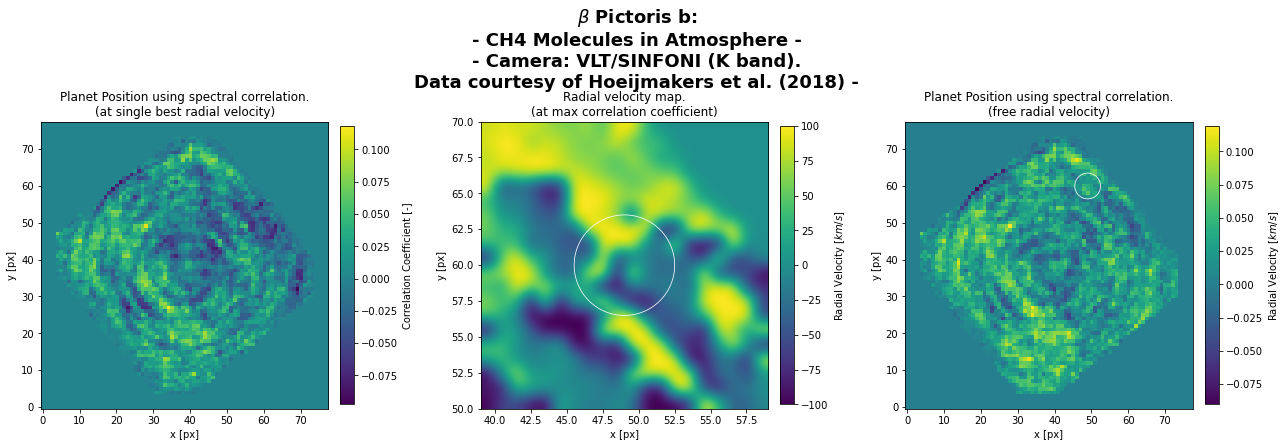

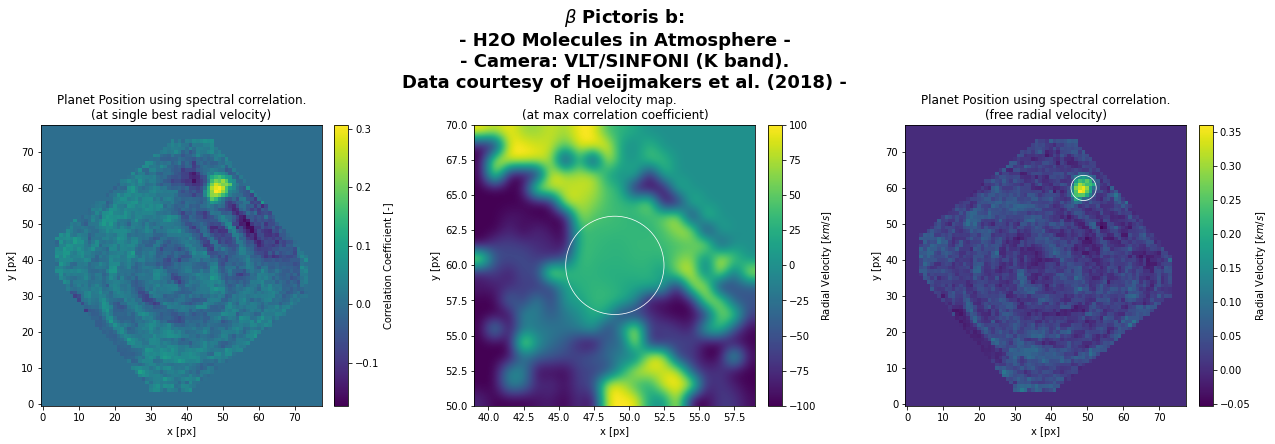

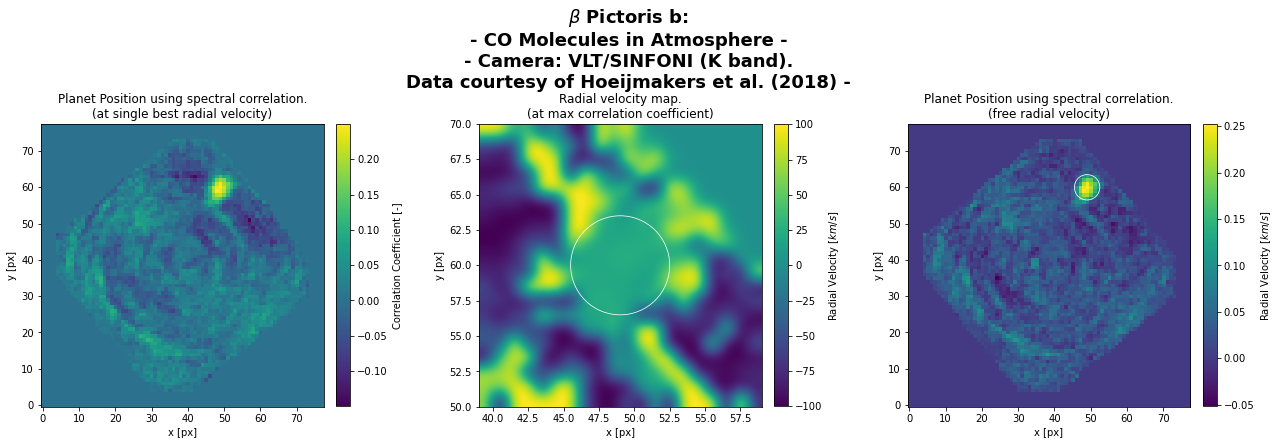

In [20]:
# Im not really plotting at 20 km/s because that would be boring right?
# I get that the idea is that we know from other measurements what the radial velocity of the planet is but what if we dont?
# can we infer the radial velocity from the molecule signature we detect?
# would be cool right?
# Even better if (and this was the original idea) if we can see a shift of most probable radial velocities over the signal
# which would mean that we see the atmosphere rotating with the planet (amazing!) and we could get some better signal 
# by adjusting the radial velocity at whcih we sample over the image using the added rotation from the planet ('s atmosphere)
# doesnt quite work here though
# in any case, giving the maps for v_rad = 20km/s is trivial here obviously

rad_vel = np.linspace(-100, 100, 201) * 1000

x0 = 50
y0 = 39
width = 20
rad = 3.5

detected_rad_vel = np.zeros((2, 3))
detected_rad_vel_std = np.zeros((2, 3))

for i in range(3):
    corrcoef = np.zeros((masked_pca_subtracted.shape[0], rad_vel.size), dtype=float)
    best_corrcoef_img = np.zeros(mask.shape, dtype=float)
    best_corrcoef_img_v = np.zeros(mask.shape, dtype=float)
    best_corrcoef_img_free = np.zeros(mask.shape, dtype=float)
    for j, target in enumerate(masked_pca_subtracted):
        ccc = cross_correlate(target, wave, hdul_mol[i+2].data, mol_wave, rad_vel)
        corrcoef[j] = ccc
    
    # find best autocorr from v range
    best_idx = np.argmax(np.sum(corrcoef, axis=0))
    best_corrcoef = corrcoef[:, best_idx]
    best_corrcoef_img[~mask] = best_corrcoef
    
    # find best v from autocorr range
    best_idx_v = np.argmax(corrcoef, axis=1)
    best_corrcoef_v = rad_vel[best_idx_v]
    best_corrcoef_img_v[~mask] = best_corrcoef_v
    
    # find best autocorr, free from velocity
    best_corrcoef_free = np.max(corrcoef, axis=1)
    best_corrcoef_img_free[~mask] = best_corrcoef_free
    
    fig, (ax, ax1, ax2) = plt.subplots(nrows=1, ncols=3,
                                       constrained_layout=True,
                                       figsize=(18, 6)) # figsize=(width, height)

    name = hdul_mol[i+2].name
    
    this_im = ax.imshow(best_corrcoef_img,
                        vmax=None, vmin=None)
    plt.colorbar(this_im, ax=ax, label=r"Correlation Coefficient [-]", fraction=0.046, pad=0.04)
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_title('Planet Position using spectral correlation.\n(at single best radial velocity)') 
    
    planet_vel = best_corrcoef_img_v[x0:x0+width, y0:y0+width] / 1000.
                            
    p_mask, __ = r_theta(planet_vel, width/2, width/2)
    p_mask = p_mask <= rad
    
    detected_rad_vel[0, i] = np.median(planet_vel[p_mask])
    detected_rad_vel_std[0, i] = np.std(planet_vel[p_mask])
    
    this_im = ax1.imshow(planet_vel,
                        vmax=np.max(rad_vel) / 1000., vmin=np.min(rad_vel) / 1000.,
                        interpolation='bicubic',
                        extent=[y0, y0+width, x0, x0+width])
    plt.colorbar(this_im, ax=ax1, label=r"Radial Velocity [$km/s$]", fraction=0.046, pad=0.04)
    
    circ = Circle((y0 + width/2, x0 + width/2), rad,
                 facecolor=None, edgecolor="w", antialiased=True, lw=0.75, fill=False)
    ax1.add_patch(circ)
    
    ax1.set_xlabel('x [px]')
    ax1.set_ylabel('y [px]')
    ax1.set_title('Radial velocity map.\n(at max correlation coefficient)') 
    
    
    this_im = ax2.imshow(best_corrcoef_img_free,
                        vmax=None, vmin=None)
    plt.colorbar(this_im, ax=ax2, label=r"Radial Velocity [$km/s$]", fraction=0.046, pad=0.04)
    
    circ = Circle((y0 + width/2, x0 + width/2), rad,
                 facecolor=None, edgecolor="w", antialiased=True, lw=0.75, fill=False)
    ax2.add_patch(circ)
    
    ax2.set_xlabel('x [px]')
    ax2.set_ylabel('y [px]')
    ax2.set_title('Planet Position using spectral correlation.\n(free radial velocity)') 
    
    
    fig.suptitle(r'$\beta$ Pictoris b:'
                 f'\n- {name} Molecules in Atmosphere -'
                 f'\n- Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018) -',
                 fontsize=18, weight="bold")
    plt.show()


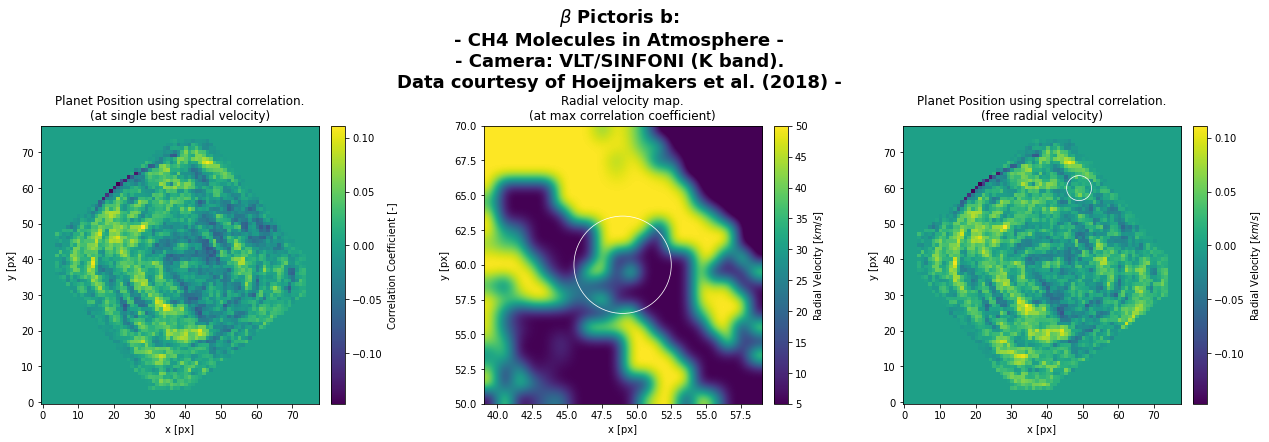

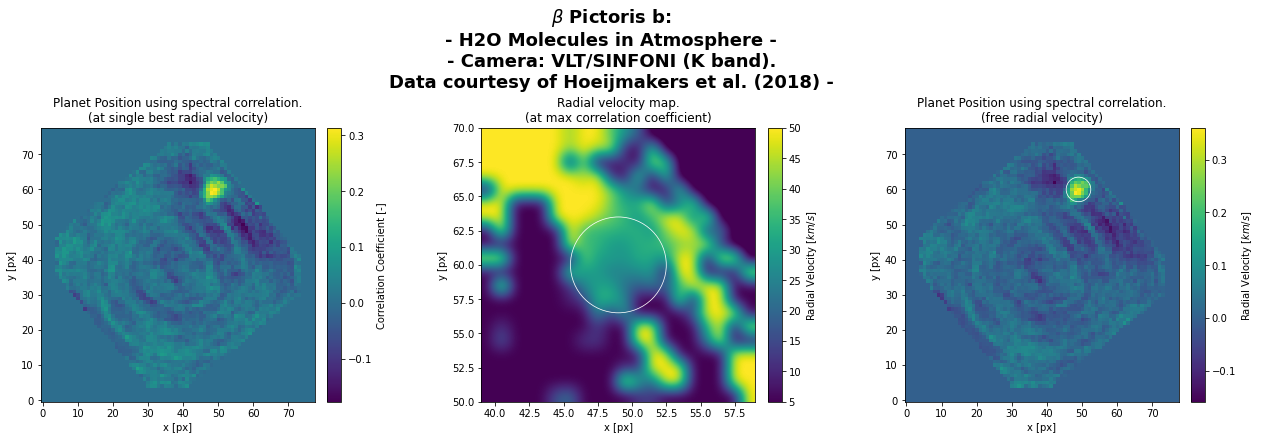

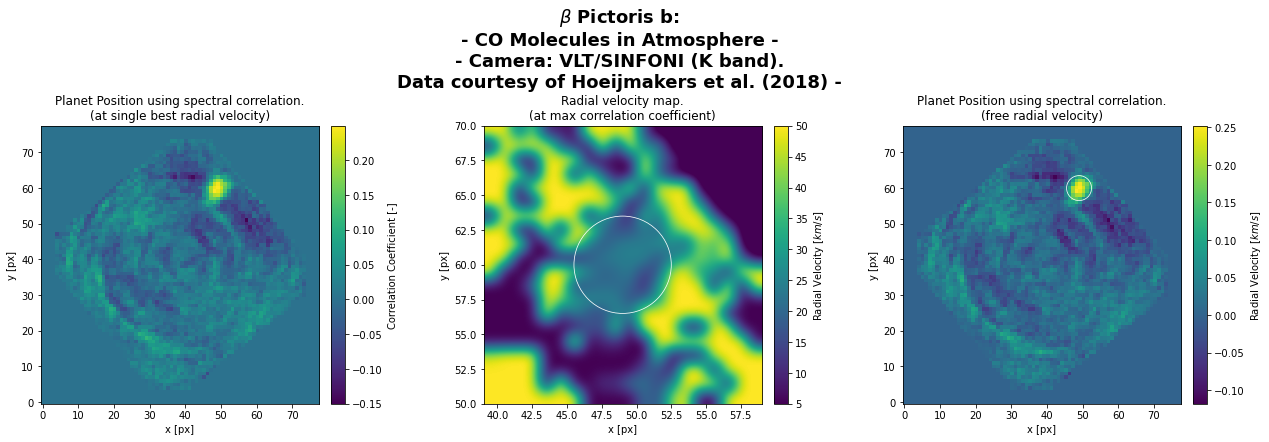

In [21]:
rad_vel = np.linspace(5, 50, 201) * 1000

for i in range(3):
    corrcoef = np.zeros((masked_pca_subtracted.shape[0], rad_vel.size), dtype=float)
    best_corrcoef_img = np.zeros(mask.shape, dtype=float)
    best_corrcoef_img_v = np.zeros(mask.shape, dtype=float)
    best_corrcoef_img_free = np.zeros(mask.shape, dtype=float)
    for j, target in enumerate(masked_pca_subtracted):
        ccc = cross_correlate(target, wave, hdul_mol[i+2].data, mol_wave, rad_vel)
        corrcoef[j] = ccc
    
    
    
    # find best autocorr from v range
    best_idx = np.argmax(np.sum(corrcoef, axis=0))
    best_corrcoef = corrcoef[:, best_idx]
    best_corrcoef_img[~mask] = best_corrcoef
    
    # find best v from autocorr range
    best_idx_v = np.argmax(corrcoef, axis=1)
    best_corrcoef_v = rad_vel[best_idx_v]
    best_corrcoef_img_v[~mask] = best_corrcoef_v
    
    # find best autocorr, free from velocity
    best_corrcoef_free = np.max(corrcoef, axis=1)
    best_corrcoef_img_free[~mask] = best_corrcoef_free
    
    fig, (ax, ax1, ax2) = plt.subplots(nrows=1, ncols=3,
                                       constrained_layout=True,
                                       figsize=(18, 6)) # figsize=(width, height)

    name = hdul_mol[i+2].name
    
    this_im = ax.imshow(best_corrcoef_img,
                        vmax=None, vmin=None)
    plt.colorbar(this_im, ax=ax, label=r"Correlation Coefficient [-]", fraction=0.046, pad=0.04)
    ax.set_xlabel('x [px]')
    ax.set_ylabel('y [px]')
    ax.set_title('Planet Position using spectral correlation.\n(at single best radial velocity)') 
    

    planet_vel = best_corrcoef_img_v[x0:x0+width, y0:y0+width] / 1000.
    
    p_mask, __ = r_theta(planet_vel, width/2, width/2)
    safe_p_mask = np.copy(p_mask)
    p_mask = p_mask <= rad
    
    detected_rad_vel[1, i] = np.median(planet_vel[p_mask])
    detected_rad_vel_std[1, i] = np.std(planet_vel[p_mask])
    
    this_im = ax1.imshow(planet_vel,
                        vmax=np.max(rad_vel) / 1000., vmin=np.min(rad_vel) / 1000.,
                        interpolation='bicubic',
                        extent=[y0, y0+width, x0, x0+width])
    plt.colorbar(this_im, ax=ax1, label=r"Radial Velocity [$km/s$]", fraction=0.046, pad=0.04)
    
    circ = Circle((y0 + width/2, x0 + width/2), rad,
                 facecolor=None, edgecolor="w", antialiased=True, lw=0.75, fill=False)
    ax1.add_patch(circ)
    
    ax1.set_xlabel('x [px]')
    ax1.set_ylabel('y [px]')
    ax1.set_title('Radial velocity map.\n(at max correlation coefficient)') 
    
    
    this_im = ax2.imshow(best_corrcoef_img_free,
                        vmax=None, vmin=None)
    plt.colorbar(this_im, ax=ax2, label=r"Radial Velocity [$km/s$]", fraction=0.046, pad=0.04)
    
    circ = Circle((y0 + width/2, x0 + width/2), rad,
                 facecolor=None, edgecolor="w", antialiased=True, lw=0.75, fill=False)
    ax2.add_patch(circ)
    
    ax2.set_xlabel('x [px]')
    ax2.set_ylabel('y [px]')
    ax2.set_title('Planet Position using spectral correlation.\n(free radial velocity)') 
    
    
    fig.suptitle(r'$\beta$ Pictoris b:'
                 f'\n- {name} Molecules in Atmosphere -'
                 f'\n- Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018) -',
                 fontsize=18, weight="bold")
    plt.show()


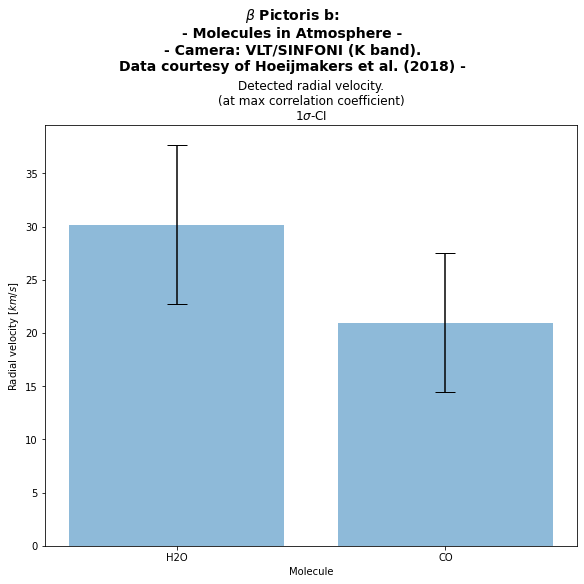

In [22]:
# rad vel
# detected_rad_vel
# detected_rad_vel_std

fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(8, 8))


ax.bar(np.arange(2), detected_rad_vel[1,1:], yerr=detected_rad_vel_std[1,1:],
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Coefficient of Thermal Expansion ($\degree C^{-1}$)')
ax.set_xticks(np.arange(2))
ax.set_xticklabels(["H2O", "CO"])
ax.set_title('Detected radial velocity.\n(at max correlation coefficient)\n'r"$1\sigma$-CI")


ax.set_xlabel(r'Molecule')
ax.set_ylabel(r'Radial velocity [$km/s$]')

fig.suptitle(r'$\beta$ Pictoris b:'
             f'\n- Molecules in Atmosphere -'
             f'\n- Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018) -',
             fontsize=14, weight="bold")
plt.show()

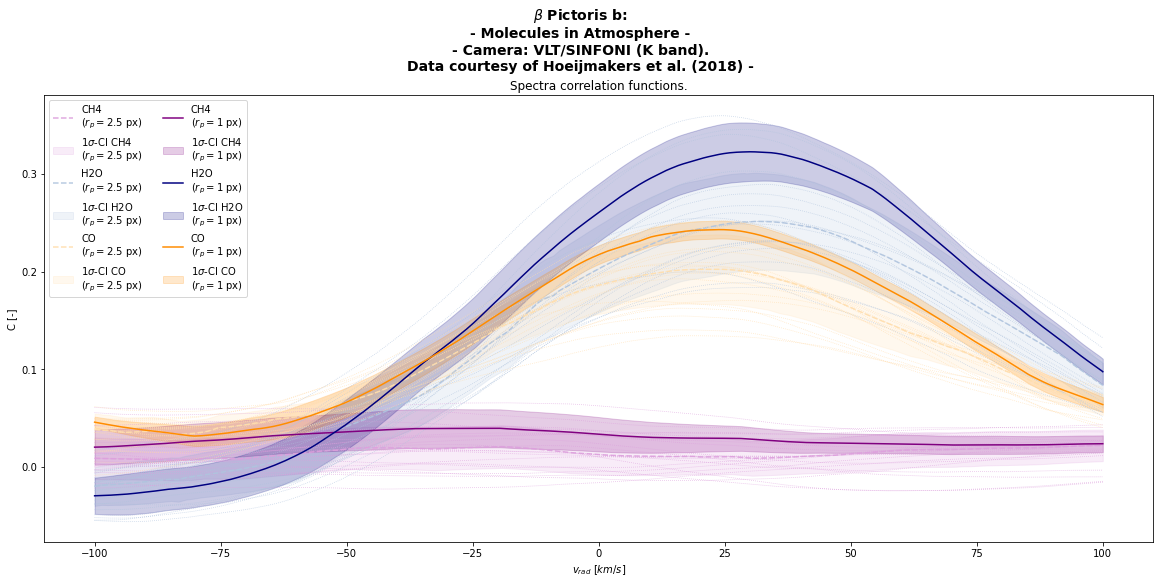

In [23]:
# correlation functions
rad_vel = np.linspace(-100, 100, 1001) * 1000
p_rad = 2.5

# safe_p_mask
# plt.imshow(safe_p_mask)
# plt.show()

p_mask_idxs = np.array(np.nonzero(safe_p_mask <= p_rad))

p_mask_idxs[0] = p_mask_idxs[0] + x0
p_mask_idxs[1] = p_mask_idxs[1] + y0
p_mask_idxs = tuple(p_mask_idxs)


fig, ax = plt.subplots(nrows=1, ncols=1,
                         constrained_layout=True,
                         figsize=(16, 8),
                             sharex=True)

colors = ["plum", "lightsteelblue", "navajowhite"]
for i, (col, ) in enumerate(zip(colors, )):
    y = hdul_mol[i + 2].data
    name = hdul_mol[i+2].name
    
    _corr = np.zeros((len(p_mask_idxs[0]), len(rad_vel)))
    for j, (_x, _y) in enumerate(zip(*p_mask_idxs)):
        x = pca_subtracted[_x, _y]
        mol_corr = cross_correlate(x, wave, y, mol_wave, rad_vel)
        
        _corr[j] = mol_corr
        
        
        ax.plot(rad_vel/1000., mol_corr, ls="dotted", alpha=0.8, lw=0.75,
                c=col)
    
    
    corr_med = np.median(_corr, axis=0)
    corr_std = np.std(_corr, axis=0)
    
    ax.plot(rad_vel/1000., corr_med, ls="dashed", alpha=0.9, lw=1.5,
            c=col, label=name + f"\n"r"($r_p=2.5$ px)")
    
    ax.fill_between(rad_vel/1000.,
                   corr_med + corr_std,
                   corr_med - corr_std,
                   color=col, alpha=0.2,
                   label=r"$1\sigma$-CI " + name + f"\n"r"($r_p=2.5$ px)")

p_rad = 1.

# safe_p_mask
# plt.imshow(safe_p_mask)
# plt.show()

p_mask_idxs = np.array(np.nonzero(safe_p_mask <= p_rad))

p_mask_idxs[0] = p_mask_idxs[0] + x0
p_mask_idxs[1] = p_mask_idxs[1] + y0
p_mask_idxs = tuple(p_mask_idxs)


colors = ["purple", "navy", "darkorange"]
for i, (col, ) in enumerate(zip(colors, )):
    y = hdul_mol[i + 2].data
    name = hdul_mol[i+2].name
    
    _corr = np.zeros((len(p_mask_idxs[0]), len(rad_vel)))
    for j, (_x, _y) in enumerate(zip(*p_mask_idxs)):
        x = pca_subtracted[_x, _y]
        mol_corr = cross_correlate(x, wave, y, mol_wave, rad_vel)
        
        _corr[j] = mol_corr
    
    
    corr_med = np.median(_corr, axis=0)
    corr_std = np.std(_corr, axis=0)
    
    ax.plot(rad_vel/1000., corr_med, ls="solid", alpha=1., lw=1.5,
            c=col, label=name + f"\n"r"($r_p=1$ px)")
    
    ax.fill_between(rad_vel/1000.,
                   corr_med + corr_std,
                   corr_med - corr_std,
                   color=col, alpha=0.2,
                   label=r"$1\sigma$-CI " + name + f"\n"r"($r_p=1$ px)")

ax.set_ylabel(r'C [-]')
ax.set_xlabel(r'$v_{rad}$ [$km/s$]')
ax.legend(ncol=2)

ax.set_title('Spectra correlation functions.')
fig.suptitle(r'$\beta$ Pictoris b:'
             f'\n- Molecules in Atmosphere -'
             f'\n- Camera: VLT/SINFONI (K band).\nData courtesy of Hoeijmakers et al. (2018) -',
             fontsize=14, weight="bold")
plt.show()

---
<span style="  font-size:2em; color: SteelBlue;">Question 9.9</span> <span style="  font-size:1em; color: SteelBlue;">
(1 point): </span>

**Which molecules are present in the atmosphere of $\beta$ Pictoris b?**

In [24]:
# Q9 answer here

print("The following molecules are present in the atmosphere of the companion: ")

# Q9 end of answer

The following molecules are present in the atmosphere of the companion: 


H2O and CO probably. We still only have an correlation coefficeint of < 0.4 so that we cannot say for sure, but judging from the images and plot, especially the ccf its very likely for H2O and CO to be present and very unlikely for CH4 to be present. Considering that other molecules might also be present and we did not clean the "known" molecules from the spectrum to make detection of other molecules more significant Id say its a confirmed detection for us with approx. >5 sigma for both H2O and CO. Sweet!

One interesting thing we detect is the different median radial velocities of the molecules. While they are almost within 1 sigma, it is interesting to speculate that we see just one side of the planets atmosphere and the different molecules are at slightly different altitudes and thus we see different (stacked) rotational velocities. However, since the difference here looks to be on the order of some km/s and the molecules are (somewhat) similar (please dont tell the chemists I said that) Id say that is unlikely. Nevertheless, considering the size of the planet Id also not rule it out, especially if its a very latitudinally differentiated atmosphere.


<div class="alert alert-block alert-info">
<b>REMEMBER:</b> to make sure your code compiles cleanly before submitting it! Do <b>NOT</b> send your fits cubes back! Only this Jupyter notebook!</div>

**Thank you for submitting all the Jupyter notebooks during the last nine weeks. We hope you enjoyed the tutorials and that you now understand the concepts of (and how to apply) different techniques used in High Contrast Imaging.**

---
<span style="  font-size:2em; color: SteelBlue;">Your time has a value as well</span> 
 </span>

---

### How long did this Practicum take?
Please enter the number of hours you spent on this Practicum (including the time spend besides the time spend during the Lecture) below:


In [25]:
# Number of hours taken for this practicum:
# probably like 8 or 9 hours, not sure

# Was really fun, to do, especially once I figured out what was wanted from us. 
# I think the task descriptions could use some rework/or rather more precision 
# (i.e. rotation direction, +/- 20 km radial velocity)
# oh and the worst part: cen_rot2 just has an error in the docstring as far as I understand it, really, really annying, doesnt take arrays as inputs
# maybe also consider putting the imports outside of functionst that will get called a few hundred times to make our life easier

# but yeah all in all I had a blast as you can probably tell, great fun
# also all the tutorials in general were super nice, I think I really learned a lot. Thanks for grading them so quickly as well every week. 
# Its very satisfying and pleasant for me to get the feedback on it so quickly. Very motivating!

# I think Ill actuall be sad to not have any new tutorials coming in weekly, they really became a nice routine.
# Thanks a bunch again, was great!